## Assignment \#1 : Estimating the Distance to the Pleiades

Pleiades is an open star cluster located at approximately $(RA, \, DEC)_{2000} = (3h47m, +24^\circ 03')$ and approximately $450 \, [ly]$ ($\simeq 4\times 10^{15} \, [km]$) away. The goal of this assignment is to estimate the distance to this cluster using a sample from the Hipparcos catalog.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

___
## Retrieving Data from the Hipparcos Catalog

The recent Hipparcos catalog (I/311) is available on Vizier, located [here](http://cdsarc.u-strasbg.fr/viz-bin/VizieR?-meta.foot&-source=I/311). We will extract the data automatically using the _astroquery_ library&mdash;an _astropy_ affilited package&mdash; which can be used to access online astronomical data.

In [2]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs('I/311')

print({k:v.description for k,v in catalog_list.items()})

Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())

{'I/311': 'Hipparcos, the New Reduction (van Leeuwen, 2007)'}


Searching for the Pleiades in the catalog

In [3]:
from astropy.coordinates import Angle
Vizier.TIMEOUT = 60 # sets the timeout to 60s

# Only extract the following quantities
v = Vizier(columns=['HIP', 'RArad','DErad', 'Plx', 'e_Plx', 'pmRA', 'pmDE', 'B-V', 'V-I', 'Hpmag', 'e_Hpmag'])
       
# Query the catalog around Pleiades with a search radius of 2 degrees
result = v.query_region("pleiades", radius=Angle(2.0, "deg"), catalog="I/311/")

df = result['I/311/hip2'].to_pandas()

In [4]:
print(f"{len(df.index)} Stars Retrieved...")

# The Parallax (Plx) is given in milli-arcsecond, so let us convert it to arcseconds.
df.Plx = df.Plx * 1e-3
df.e_Plx = df.e_Plx * 1e-3

df.head()

47 Stars Retrieved...


,HIP,RArad,DErad,Plx,e_Plx,pmRA,pmDE,B-V,V-I,Hpmag,e_Hpmag
0,16996.0,54.649570,24.601687,0.00896,0.00107,3.47,-22.69,0.428,0.50,8.3007,0.0012
1,17020.0,54.736883,24.569915,0.00298,0.00275,21.24,-44.93,0.645,0.71,10.6845,0.0041
2,17034.0,54.777958,24.702983,0.00832,0.00079,23.91,-45.11,0.039,0.05,7.1287,0.0008
3,17044.0,54.806084,24.466631,0.01019,0.00219,23.24,-43.11,0.616,0.68,10.5328,0.0040
4,17091.0,54.921506,23.290987,0.01182,0.00194,26.82,-44.23,0.608,0.68,10.0767,0.0050


## Visual Inspection of the Data

Mean Distance = 111.47 [pc]


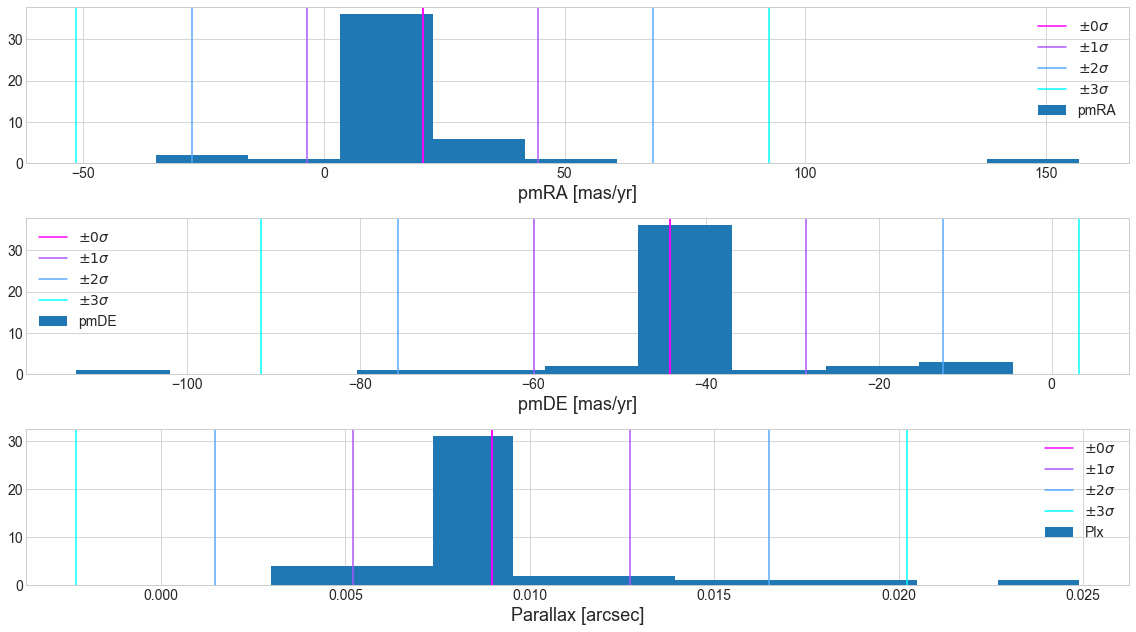

In [12]:
fig, axarr = plt.subplots(3, figsize=(16,9))

axarr[0].hist(df.pmRA)
axarr[1].hist(df.pmDE)
axarr[2].hist(df.Plx)


for i, color in enumerate(plt.cm.cool(np.linspace(1, 0, 4))):
    axarr[0].axvline(df.pmRA.mean() + (i)*df.pmRA.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[0].axvline(df.pmRA.mean() - (i)*df.pmRA.std(), color=color)
    
    axarr[0].set_xlabel('pmRA [mas/yr]')
    axarr[0].legend(loc='best')
    
    axarr[1].axvline(df.pmDE.mean() + (i)*df.pmDE.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[1].axvline(df.pmDE.mean() - (i)*df.pmDE.std(), color=color)

    axarr[1].set_xlabel('pmDE [mas/yr]')
    axarr[1].legend(loc='best')
    
    axarr[2].axvline(df.Plx.mean() + (i)*df.Plx.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[2].axvline(df.Plx.mean() - (i)*df.Plx.std(), color=color)
    axarr[2].set_xlabel('Parallax [arcsec]')
    axarr[2].legend(loc='best')

plt.tight_layout()
plt.savefig('histograms.png', dpi=150, bbox_inches='tight')

print(f"Mean Distance = {'{:.2f}'.format(1/df.Plx.mean())} [pc]")

As we can see, there are a spread of Parallax measurements, which is indicative of contaimination from foreground (or background) stars.

___
## Color-Magnitude Diagram

Here we plot a color-magnitude diagram for the Pleiades members with the parallax represeted by color.

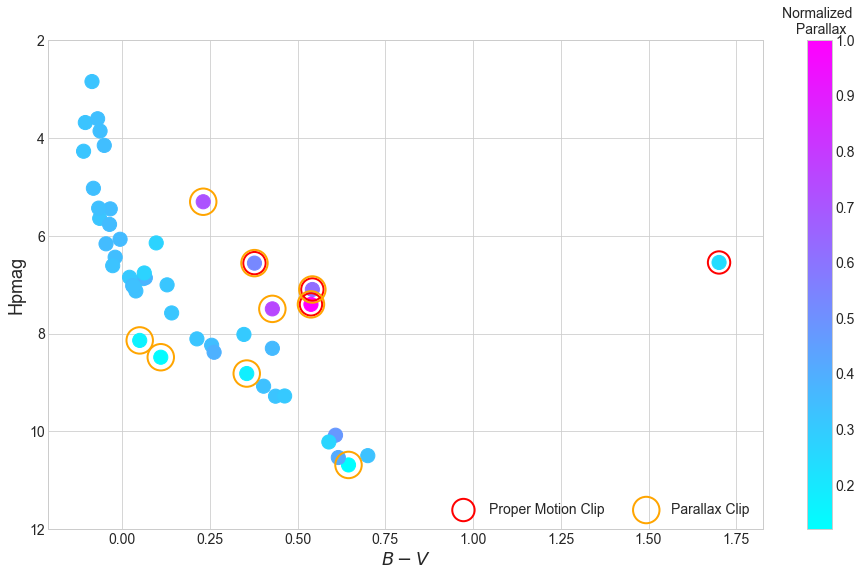

In [83]:
fig = plt.figure(figsize=(16,9))

plt.scatter(df["B-V"], df.Hpmag, c=df.Plx/df.Plx.max(), cmap=plt.cm.cool, s=200, label='')
clb = plt.colorbar()
clb.ax.set_title('Normalized \n Parallax')

## -- Proper Motion Clipping
pm_df = df[(df.pmRA > df.pmRA.median()+1.0*df.pmRA.std()) | (df.pmRA < df.pmRA.median()-1.0*df.pmRA.std())]
plt.scatter(pm_df["B-V"], pm_df.Hpmag, s=500, facecolors='none', edgecolors= 'red', lw=2, label='Proper Motion Clip')


## -- Parallax Clipping
plx_df = df[(df.Plx > df.Plx.median() + 1.0*df.Plx.std()) | (df.Plx < df.Plx.median() - 1.0*df.Plx.std())]
plt.scatter(plx_df["B-V"], plx_df.Hpmag, s=700, facecolors='none', edgecolors= 'orange', lw=2, label='Parallax Clip')

plt.ylim(12, 2)
plt.xlabel('$B-V$')
plt.ylabel('Hpmag')
plt.legend(loc=4, ncol=2)

plt.savefig('color-mag.png', dpi=150, bbox_inches='tight')

___
## Removing Foreground and Background Stars

In [84]:
trim_df = df[((df.pmRA < df.pmRA.median()+1.0*df.pmRA.std()) & (df.pmRA > df.pmRA.median()-1.0*df.pmRA.std())) 
             & 
             ((df.Plx < df.Plx.median() + df.Plx.std()) & (df.Plx > df.Plx.median() - df.Plx.std()))]

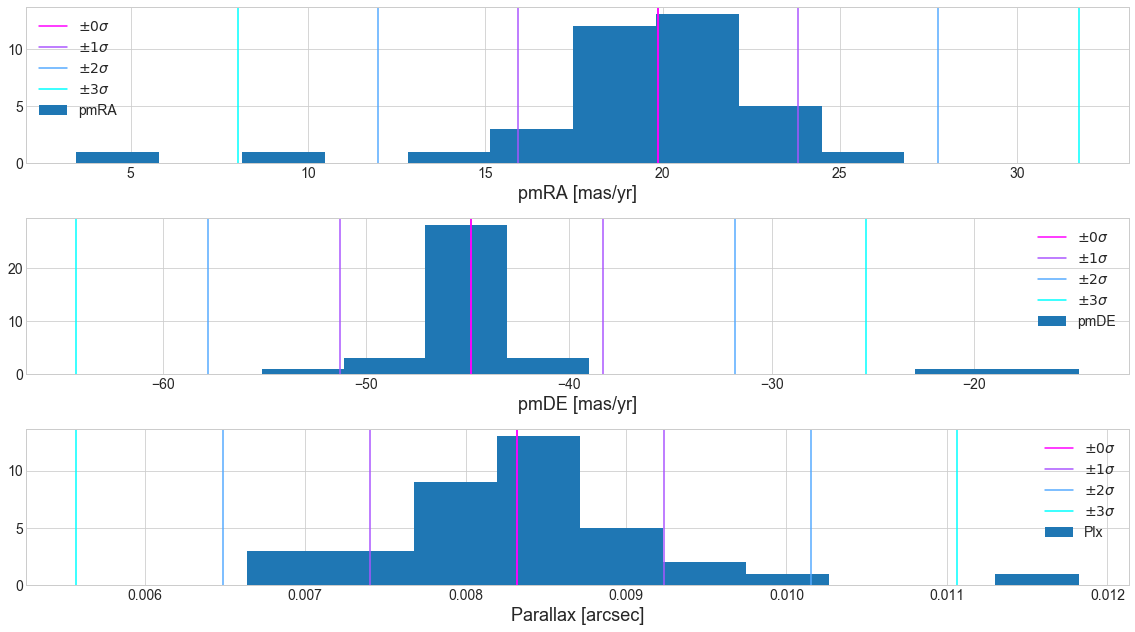

In [85]:
fig, axarr = plt.subplots(3, figsize=(16,9))

axarr[0].hist(trim_df.pmRA)
axarr[1].hist(trim_df.pmDE)
axarr[2].hist(trim_df.Plx)


for i, color in enumerate(plt.cm.cool(np.linspace(1, 0, 4))):
    axarr[0].axvline(trim_df.pmRA.median() + (i)*trim_df.pmRA.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[0].axvline(trim_df.pmRA.median() - (i)*trim_df.pmRA.std(), color=color)
    
    axarr[0].set_xlabel('pmRA [mas/yr]')
    axarr[0].legend(loc='best')
    
    axarr[1].axvline(trim_df.pmDE.median() + (i)*trim_df.pmDE.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[1].axvline(trim_df.pmDE.median() - (i)*trim_df.pmDE.std(), color=color)

    axarr[1].set_xlabel('pmDE [mas/yr]')
    axarr[1].legend(loc='best')
    
    axarr[2].axvline(trim_df.Plx.median() + (i)*trim_df.Plx.std(), color=color, label=f'$\pm {i}\sigma$')
    axarr[2].axvline(trim_df.Plx.median() - (i)*trim_df.Plx.std(), color=color)
    axarr[2].set_xlabel('Parallax [arcsec]')
    axarr[2].legend(loc='best')

plt.tight_layout()
plt.savefig('histograms_clip.png', dpi=150, bbox_inches='tight')

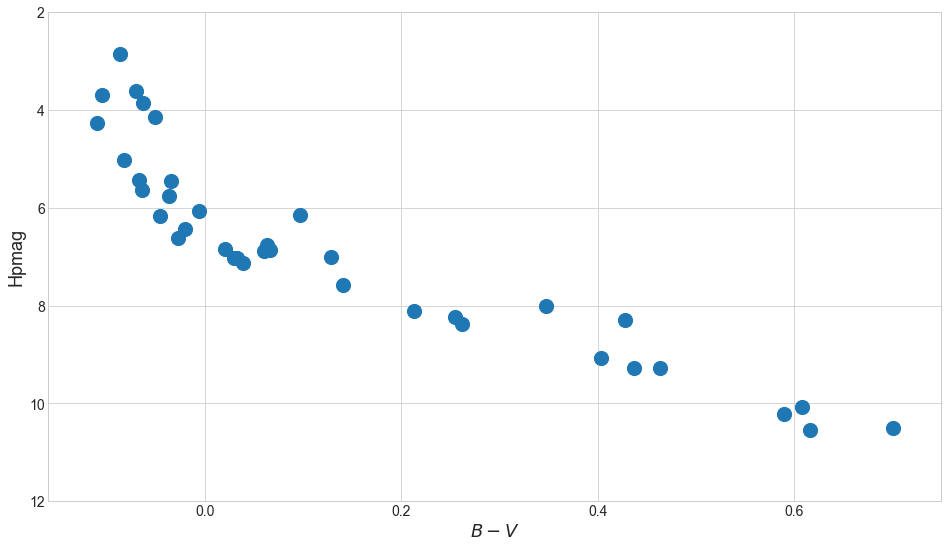

In [86]:
fig = plt.figure(figsize=(16,9))

plt.scatter(trim_df["B-V"], trim_df.Hpmag, s=200, label='')

plt.ylim(12, 2)
plt.xlabel('$B-V$')
plt.ylabel('Hpmag')
#plt.legend(loc=4, ncol=2)

plt.savefig('color-mag_trim.png', dpi=150, bbox_inches='tight')

___
## Sample Statistics

In [90]:
from uncertainties import ufloat
from uncertainties.umath import *

plx = ufloat(df.Plx.mean(), df.Plx.std())
plx_trim = ufloat(trim_df.Plx.mean(), trim_df.Plx.std())

true_dist = ufloat(136.2, 5) #Gaia Data Release 2

print(f"True Distance to the Pleiades: {true_dist} [pc]", "\n")

print("\t Before sigma-clipping")
print(f"Numer of stars in the sample: {df.Plx.shape[0]}")
print(f"Average Distance = {'{:.2f}'.format(1/plx)} [pc]")
print(f"Z-score = {'{:.2f}'.format((true_dist.n - 1/plx.n)/(1/plx.s))}")
print(f"Distance Modulus = {-5.0+5.0* log10(1/plx)}")

print()
print("\t After sigma-Clipping")
print(f"Numer of stars in the sample: {trim_df.Plx.shape[0]}")
print(f"Average Distance = {'{:.2f}'.format(1/plx_trim)} [pc]")
print(f"Z-score = {'{:.2f}'.format((true_dist.n - 1/plx_trim.n)/(1/plx_trim.s))}")
print(f"Distance Modulus = {-5.0+5.0* log10(1/plx_trim)}")

True Distance to the Pleiades: 136+/-5 [pc] 

	 Before sigma-clipping
Numer of stars in the sample: 47
Average Distance = 111.47+/-46.67 [pc]
Z-score = 0.09
Distance Modulus = 5.2+/-0.9

	 After sigma-Clipping
Numer of stars in the sample: 37
Average Distance = 119.13+/-12.99 [pc]
Z-score = 0.02
Distance Modulus = 5.38+/-0.24
